In [1]:
import numpy as np
import pandas as pd

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
myfont = FontProperties(fname=r'/Library/Fonts/Microsoft/Microsoft Jhenghei.ttf')

import seaborn as sns
import csv
import os
%matplotlib inline
#sns.set()

<a id='0'></a>
# Outline

- Raw data in this project is generated from MRT_Cleaning_Visualizing.



## [Part 1 Data Preparation](#1)

## [Part 2 Visualize with Bar Graph](#2)
</br>

<a id='1'></a>
## [Part 1 Data Preparation](#0)
</br>

In [2]:
#1.1 
#Read MRT data and change data type into proper type to reduce memory usage

df = pd.read_csv('2018_avg_2.csv')
df['entrance'] = df['entrance'].astype('category')
df['exit'] = df['exit'].astype('category')
df['c_entrance'] = df['c_entrance'].astype('category')
df['c_exit'] = df['c_exit'].astype('category')
df['od'] = df['od'].astype('category')
df['avg_ppl'] = df['avg_ppl'].round(2)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749600 entries, 0 to 1749599
Data columns (total 8 columns):
weekday       int64
time          int64
entrance      category
exit          category
od            category
c_entrance    category
c_exit        category
avg_ppl       float64
dtypes: category(5), float64(1), int64(2)
memory usage: 51.7 MB


In [3]:
df.head()

,weekday,time,entrance,exit,od,c_entrance,c_exit,avg_ppl
0,0,0,七張,七張,七張_七張,G03,G03,0.85
1,0,0,七張,三重,七張_三重,G03,O15,0.11
2,0,0,七張,中山,七張_中山,G03,G14,0.53
3,0,0,七張,丹鳳,七張_丹鳳,G03,O20,0.38
4,0,0,七張,內湖,七張_內湖,G03,BR19,0.17


In [4]:
#1.2 
#In normal condition, there are no data at 2, 3 and 4 o'clock in the morning except new year.
#Drop the data of those 3 hours since they're not needed in this project.

df = df.drop(df[(df['time'] == 2) | (df['time'] == 3) | (df['time'] == 4)].index)
df['time'].value_counts()

23    81648
12    81648
1     81648
5     81648
6     81648
7     81648
8     81648
9     81648
10    81648
11    81648
13    81648
22    81648
14    81648
15    81648
16    81648
17    81648
18    81648
19    81648
20    81648
21    81648
0     81648
Name: time, dtype: int64

In [5]:
#1.3
#Read the file which contains location data and area_code of stations.
#The area_code is generated based on districts and Voronoi diagram.
#In Tapei CBD area, the area code is station itself, 
# while outside CBD area, the area code is the district it belongs to.

df_code = pd.read_csv('station_code_with_VorDistrict_2.csv')
df_code['area_code'] = df_code['area_code'].str.replace('District', 'Dist.')
df_code[['站名','Eng','lat','long','code','area_code']].head()

,站名,Eng,lat,long,code,area_code
0,忠孝復興站,Zhongxiao Fuxing,25.04163,121.54377,BL15,BL15
1,南港展覽館站,Taipei Nangang Exhibition Center,25.05539,121.61827,BL23,Nangang Dist.
2,松山機場站,Songshan Airport,25.06302,121.55177,BR13,BR13
3,中山國中站,Zhongshan Junior High School,25.06085,121.54423,BR12,BR12
4,南京復興站,Nanjing Fuxing,25.05210,121.54435,G16,G16


In [6]:
#Illustrate the number of stations in each District
df_code['area_code'].value_counts()

Beitou Dist.       9
Wenshan Dist.      7
Sanzhong Dist.     7
Neihu Dist.        7
Xinzhuang Dist.    5
Nangang Dist.      5
Xindian Dist.      5
Banqiao Dist.      5
Tucheng Dist.      4
Zhonghe Dist.      3
Shilin Dist.       3
Danshui Dist.      3
Luzhou Dist.       2
O09                1
G08                1
BR07               1
BL16               1
G11                1
BL18               1
R05                1
O10                1
BL14               1
G13                1
G14                1
O11                1
G10                1
Yonghe Dist.       1
BL13               1
R02                1
BR14               1
R12                1
R09                1
R03                1
BR06               1
R14                1
BL17               1
G19                1
BL15               1
G07                1
BR13               1
G16                1
O12                1
O05                1
R06                1
BL12               1
BR12               1
G18                1
BR15         

In [7]:
#1.4
#Merge area code with MRT data based on station code

df = df.merge(df_code[['code','area_code']], left_on='c_entrance', right_on='code').drop('code',axis=1).rename(index=str, columns={"area_code": "exit_area"})
df = df.merge(df_code[['code','area_code']], left_on='c_exit', right_on='code').drop('code',axis=1).rename(index=str, columns={"area_code": "entrance_area"})
df.head()

,weekday,time,entrance,exit,od,c_entrance,c_exit,avg_ppl,exit_area,entrance_area
0,0,0,七張,七張,七張_七張,G03,G03,0.85,Xindian Dist.,Xindian Dist.
1,0,1,七張,七張,七張_七張,G03,G03,0.45,Xindian Dist.,Xindian Dist.
2,0,5,七張,七張,七張_七張,G03,G03,0.13,Xindian Dist.,Xindian Dist.
3,0,6,七張,七張,七張_七張,G03,G03,2.87,Xindian Dist.,Xindian Dist.
4,0,7,七張,七張,七張_七張,G03,G03,5.09,Xindian Dist.,Xindian Dist.


In [8]:
#c_entrance is the code of entrance station, 
#c_exit is the code of exit station for given weekday and time in the row.

#If the station is in Central Business District, the area_code (exit_area, entrance_area) is itself,
#if the station is outside CBD, the area_code is the district it belongs to.
df.iloc[:600000:70000]

,weekday,time,entrance,exit,od,c_entrance,c_exit,avg_ppl,exit_area,entrance_area
0,0,0,七張,七張,七張_七張,G03,G03,0.85,Xindian Dist.,Xindian Dist.
70000,1,10,西湖,內湖,西湖_內湖,BR16,BR19,8.69,Neihu Dist.,Neihu Dist.
140000,2,17,大橋頭站,北門,大橋頭站_北門,O12,G13,0.73,O12,G13
210000,4,0,明德,士林,明德_士林,R18,R16,0.69,Beitou Dist.,Shilin Dist.
280000,5,10,後山埤,府中,後山埤_府中,BL20,BL06,10.63,Nangang Dist.,Banqiao Dist.
350000,6,17,內湖,新莊,內湖_新莊,BR19,O18,1.25,Neihu Dist.,Xinzhuang Dist.
420000,1,0,迴龍,景美,迴龍_景美,O21,G05,0.21,Xinzhuang Dist.,Wenshan Dist.
490000,2,10,忠孝新生,松山,忠孝新生_松山,BL14,G19,3.60,BL14,G19
560000,3,17,東門,淡水,東門_淡水,O06,R28,26.19,O06,Danshui Dist.


In [9]:
#1.5
#Create a table of entrance people of given weekday, time and area

entr = df.groupby(['entrance_area','time', 'weekday'],as_index=False).aggregate({'avg_ppl':'sum'})
entr.sort_values(by='avg_ppl',ascending=False).head()

,entrance_area,time,weekday,avg_ppl
2608,Banqiao Dist.,18,4,25262.25
2605,Banqiao Dist.,18,1,24634.63
2607,Banqiao Dist.,18,3,24584.21
2606,Banqiao Dist.,18,2,24143.38
2604,Banqiao Dist.,18,0,23770.80


In [10]:
#1.6
##Create a table of exit people of given weekday, time and area

exit = df.groupby(['exit_area','time', 'weekday'],as_index=False).aggregate({'avg_ppl':'sum'})
exit.sort_values(by='avg_ppl',ascending=False).head()

,exit_area,time,weekday,avg_ppl
2535,Banqiao Dist.,8,1,30950.87
2537,Banqiao Dist.,8,3,30733.71
2538,Banqiao Dist.,8,4,30297.88
2536,Banqiao Dist.,8,2,29847.26
2534,Banqiao Dist.,8,0,28647.19


In [11]:
#1.7 
#Combine 2 tables from 1.5 and 1.6

df_district = entr.merge(exit,
           left_on=['entrance_area','time','weekday'],
           right_on=['exit_area','time','weekday'])\
    .sort_values(by='avg_ppl_x',ascending=False)\
    .rename(index=str, 
            columns={"avg_ppl_x": "avg_ppl_in", "avg_ppl_y":"avg_ppl_out"})
    
df_district.head()

,entrance_area,time,weekday,avg_ppl_in,exit_area,avg_ppl_out
2608,Banqiao Dist.,18,4,25262.25,Banqiao Dist.,13479.88
2605,Banqiao Dist.,18,1,24634.63,Banqiao Dist.,11635.17
2607,Banqiao Dist.,18,3,24584.21,Banqiao Dist.,11752.91
2606,Banqiao Dist.,18,2,24143.38,Banqiao Dist.,11643.55
2604,Banqiao Dist.,18,0,23770.80,Banqiao Dist.,11268.93


In [12]:
#1.8
#Additional process for 4 edge station: BL20, BR16, BR17, R15
edge_out = df[(df['c_entrance']=='BL20') | (df['c_entrance']=='BR16') | 
              (df['c_entrance']=='BR17') | (df['c_entrance']=='R15')]
edge_out = edge_out.groupby(['c_entrance','time', 'weekday'],as_index=False) \
                    .aggregate({'avg_ppl':'sum'}).sort_values(by='avg_ppl',ascending=False)

edge_in = df[(df['c_exit']=='BL20') | (df['c_exit']=='BR16') | (df['c_exit']=='BR17') | (df['c_exit']=='R15')]
edge_in = edge_in.groupby(['c_exit','time', 'weekday'],as_index=False) \
                 .aggregate({'avg_ppl':'sum'}).sort_values(by='avg_ppl',ascending=False)
    
df_edge = edge_in.merge(edge_out,
               right_on=['c_entrance','time','weekday'],
               left_on=['c_exit','time','weekday'])\
    .sort_values(by='avg_ppl_x',ascending=False)\
    .rename(index=str, 
            columns={"avg_ppl_x": "avg_ppl_in", "avg_ppl_y":"avg_ppl_out"})

In [13]:
#1.9 
#Concate tables from 1.7 and 1.8

df_mix = pd.concat([df_district,df_edge.rename(columns={'c_exit':'entrance_area','c_entrance':'exit_area'})], ignore_index=True)


#Create new column for calculating the net flow
df_mix['net_flow'] = df_mix['avg_ppl_in'] - df_mix['avg_ppl_out']
df_mix.sort_values(by='net_flow',ascending=False)
df_mix.to_csv('district_flow.csv', float_format='%.2f', encoding='utf-8',index=False)
std = df_mix['net_flow'].describe()['std'] 
df_mix.head()

,entrance_area,time,weekday,avg_ppl_in,exit_area,avg_ppl_out,net_flow
0,Banqiao Dist.,18,4,25262.25,Banqiao Dist.,13479.88,11782.37
1,Banqiao Dist.,18,1,24634.63,Banqiao Dist.,11635.17,12999.46
2,Banqiao Dist.,18,3,24584.21,Banqiao Dist.,11752.91,12831.30
3,Banqiao Dist.,18,2,24143.38,Banqiao Dist.,11643.55,12499.83
4,Banqiao Dist.,18,0,23770.80,Banqiao Dist.,11268.93,12501.87


<a id='2'></a>
## [Part 2 Visualize with Bar Graph](#0)
</br>

In [14]:


def flow_z_score(z_score):
    if z_score <= -4:
        return 1
    elif z_score > -4 and z_score <= -3:
        return 2
    elif z_score > -3 and z_score <= -2:
        return 3
    elif z_score > -2 and z_score <= -1:
        return 4
    elif z_score > -1 and z_score < 0:
        return 5
    elif z_score >= 0 and z_score < 1:
        return 6
    elif z_score >= 1 and z_score < 2:
        return 7
    elif z_score >= 2 and z_score < 3:
        return 8
    elif z_score >= 3 and z_score < 4:
        return 9
    elif z_score >= 4:
        return 10
    
# Generate a table with needed hour only.
def avg_flow_table_weekday(df_mixture, avg_time, ascending):
    df_avg = df_mixture[(df_mixture['time']==avg_time) & ((df_mixture['weekday']!=5) & (df_mixture['weekday']!=6))] \
        .groupby(['exit_area','time'],as_index=False) \
        .aggregate({'net_flow':'mean'}).sort_values(by='net_flow',ascending=ascending)

    df_avg['z'] = df_avg['net_flow']/std
    df_avg['color_code'] = df_avg['z'].apply(flow_z_score)
    return df_avg



In [15]:
#bar chart
#https://pythonspot.com/matplotlib-bar-chart/

def bar_plot(top, n_o_bars, time, df, chinese_station, y_max=None):

    color_map = {
            1:'#313695',2:'#4575b4',3:'#74add1',4:'#abd9e9',5:'#e0f3f8',
            6:'#fee090',7:'#fdae61',8:'#f46d43',9:'#d73027',10:'#a50026',
    }
    df_hour = avg_flow_table_weekday(df,time,False)
    
    if top == True:
        N = n_o_bars
        df_plot = df_hour[:N].reset_index(drop=True)
    else:
        N = n_o_bars*-1
        df_plot = df_hour[N:].reset_index(drop=True)
    

    file_time = '{}:00'.format(str(time))
    
    
    plt.figure(figsize = (10,6))
    y_pos_ticks = np.arange(len(df_plot['exit_area']))


    x_ticks = []
    for string in list(df_plot['exit_area']):
        new_string = string
        x_ticks.append(new_string)
        
    if chinese_station== True:
        station = pd.read_csv('station_name.csv',usecols = ['ID','CH_1', 'EN_1'], index_col='ID')
        station['EN_1'] = station['EN_1'].fillna(station.index.to_series())
        station = station.to_dict()['CH_1']
        x_ticks = [station[item] if item in station.keys() else item for item in x_ticks]

    for g in df_plot['color_code'].unique():
        ypos=df_plot.index[df_plot["color_code"]==g]
        ys=df_plot["net_flow"][df_plot["color_code"]==g]
        color=color_map[g]
        plt.bar(ypos,ys,color=color,label=g)


    plt.xticks(y_pos_ticks,x_ticks,rotation='45',fontproperties=myfont)
    ax = plt.gca()
    ax.tick_params(labelsize = 15)
    if y_max is not None:
        if top == True:
            ax.set_ylim([0, y_max])
        else:
            ax.set_ylim([y_max, 0])

    plt.ylabel('People')
    if top == True:
        plt.title('Top {} Station/Area at {}'.format(n_o_bars, file_time),fontsize= 18, y=1.03)
        plt.savefig('Top_{}_{}.png'.format(n_o_bars,file_time), bbox_inches='tight')
    else:
        plt.title('Bottom {} Station/Area at {}'.format(n_o_bars, file_time),fontsize= 18, y=1.03)
        plt.savefig('Bottom_{}_{}.png'.format(n_o_bars,file_time), bbox_inches='tight')


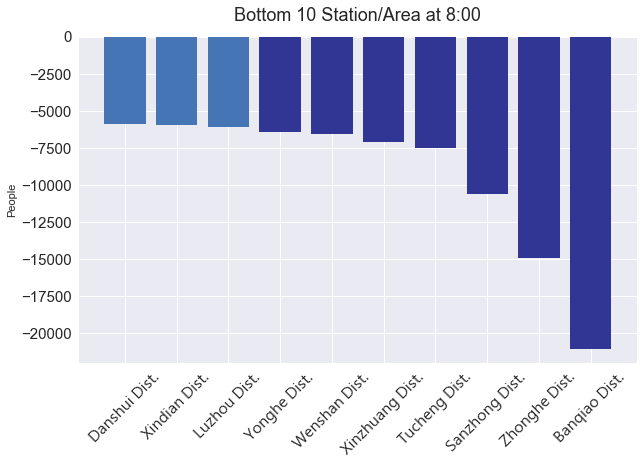

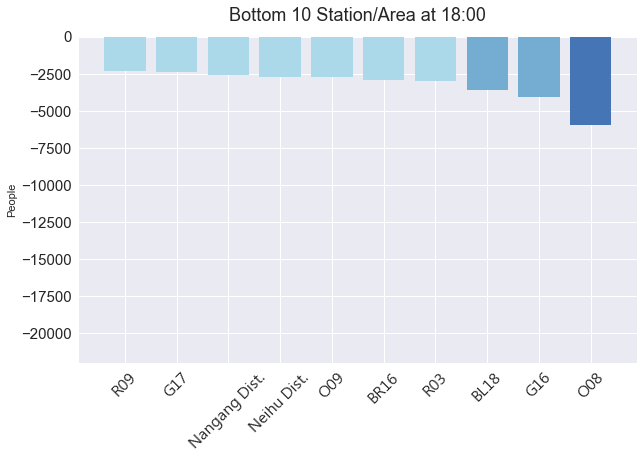

In [16]:
for time in [8,18]:
    bar_plot(top=False, n_o_bars=10, time=time, df=df_mix, chinese_station=False, y_max=-22000)

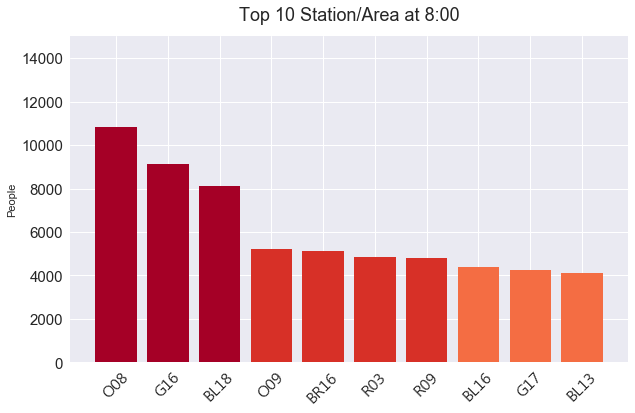

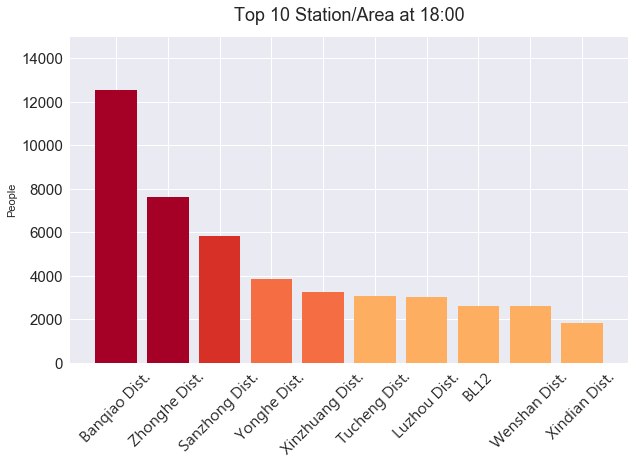

In [17]:
for time in [8,18]:
    bar_plot(top=True, n_o_bars=10, time=time, df=df_mix, chinese_station=False, y_max=15000)